<Strong> Develop a TCN model that overfits , then do some regularization , then do some tuning. </Strong>

In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from IPython.display import display, Image
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Flatten , Input , Conv1D , InputLayer , MaxPooling1D
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

In [56]:
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [57]:
btc_data = df_btc.values[:, 4 ,].astype(float)

In [58]:
df_btc

,date,open,high,low,close,volume
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...,...
39216,2022-02-11 10:00:00,43492.63,43569.67,43233.67,43443.77,1305.626920
39217,2022-02-11 11:00:00,43443.78,43523.42,43320.00,43357.53,744.524180
39218,2022-02-11 12:00:00,43357.53,43700.78,43253.31,43570.77,1317.546940
39219,2022-02-11 13:00:00,43570.77,43826.00,43503.01,43765.14,1564.251800


<Strong> Scaling the data  </Strong>

In [59]:
percTrain = 70
percVal = 20 

In [60]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Hyper-parameters </Strong>

In [61]:
# Hyper Parameters that are dependant on the number of layers 

# Dilation_rate
# window_length 
# kernel_size

# The rest of the hyper-parameter

# learning_rate
# Dense layer size
# filters 
# batch_size

window_length = 24
dilation_rate = 2
kernel_size = 2
features = 1

<Strong> Creating Matrix in Sliding window form <Strong>

In [62]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data into train , val , test </Strong>

In [63]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)


In [72]:
len(btc_train[0][1])

24

<Strong> The number of layers while changing dilation_base , kernel_size or window_size. </Strong>

In [49]:
def getLayers(dilation_rate , window_size , kernel_size):
    
    top = (dilation_rate - 1) * (window_size - 1)
    bottom = (kernel_size - 1) 
    
    division = (top / bottom) + 1 
    log = math.ceil(math.log(division , dilation_rate))
    
    
    # This inequality must hold true for full coverage
    
    first = 1 + (kernel_size - 1)
    second = (dilation_rate ** log ) - 1
    third = dilation_rate - 1
    
    inequality = (second / third) * first
    
    if ( (kernel_size < dilation_rate) or (inequality < window_size) ):
        print("not going to have full coverage")
        return False
    
    else:
        print("layers =" , log , "kernel size =" , kernel_size , "dilation rate =" , dilation_rate )
        return log , dilation_rate , kernel_size

getLayers(2 , 24 , 2)


layers = 5 kernel size = 2 dilation rate = 2


(5, 2, 2)

In [50]:
model = models.Sequential()

model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))

model.add(Conv1D(filters=32, kernel_size=2, activation='relu' , padding = 'causal', dilation_rate=2))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu' , padding = 'causal' , dilation_rate=4))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu' , padding = 'causal', dilation_rate= 8))

model.add(Conv1D(filters=128, kernel_size=2, activation='relu' , padding = 'causal', dilation_rate= 16))

model.add(Flatten())

model.add(Dense(64))

model.add(Dense(1))

model.summary()

opt = Adam(0.008)
model.compile(optimizer=opt , loss = 'mse')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 24, 32)            96        
                                                                 
 conv1d_15 (Conv1D)          (None, 24, 32)            2080      
                                                                 
 conv1d_16 (Conv1D)          (None, 24, 64)            4160      
                                                                 
 conv1d_17 (Conv1D)          (None, 24, 64)            8256      
                                                                 
 conv1d_18 (Conv1D)          (None, 24, 128)           16512     
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

<Strong> Training the model </Strong>

In [51]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300


2022-03-28 10:09:53.628966: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


54/54 [==============================] - 10s 19ms/step - loss: 0.0383 - val_loss: 0.0829
Epoch 2/300
54/54 [==============================] - 1s 15ms/step - loss: 2.6335e-04 - val_loss: 0.0303
Epoch 3/300
54/54 [==============================] - 1s 12ms/step - loss: 2.4738e-04 - val_loss: 0.0150
Epoch 4/300
54/54 [==============================] - 1s 10ms/step - loss: 3.2001e-04 - val_loss: 0.0043
Epoch 5/300
54/54 [==============================] - 1s 10ms/step - loss: 1.6602e-04 - val_loss: 0.0100
Epoch 6/300
54/54 [==============================] - 1s 10ms/step - loss: 3.1120e-04 - val_loss: 0.0061
Epoch 7/300
54/54 [==============================] - 1s 10ms/step - loss: 1.7120e-04 - val_loss: 0.0202
Epoch 8/300
54/54 [==============================] - 1s 9ms/step - loss: 1.5460e-04 - val_loss: 0.0169
Epoch 9/300
54/54 [==============================] - 1s 10ms/step - loss: 2.1639e-04 - val_loss: 0.0548
Epoch 10/300
54/54 [==============================] - 1s 10ms/step - loss: 3.386

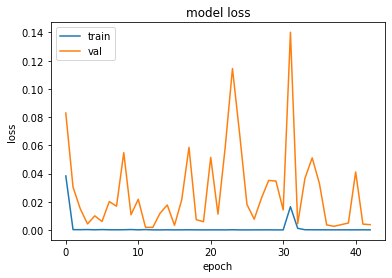

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim([0,0.01])
plt.show()